# Classifying Patient Abilify Ratings from WebMD

## Setup

In [1]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import tensorflow as tf
import gensim

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# download WordNet model for lemmatization

nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/co

In [3]:
# load dataset
# https://www.kaggle.com/datasets/joyshil0599/abilify-oral-reviews-dataset

corpus = pd.read_csv('/kaggle/input/abilify-oral-reviews-dataset/abilify_ora_effected_peple_reviewl.csv', encoding_errors='replace') # use replacement character for characters not in UTF-8
corpus = corpus[['overall-rating', 'description-text']]

print(f'Before dropping NAs: {len(corpus)}')
corpus = corpus.dropna(axis=0)
corpus = corpus.reset_index(drop=True)
print(f'After dropping NAs: {len(corpus)}')

corpus.head(5)

Before dropping NAs: 1835
After dropping NAs: 1540


,overall-rating,description-text
0,5.0,I've taken Abilify to augment bupropion for Bi...
1,2.0,Worked for 3 months. Waste of time. You think ...
2,2.3,Worked really well for like 2 months then I go...
3,1.0,This is the worst drug on the market. It cause...
4,2.0,I was prescribed as a child at 15 years old. I...


## Exploratory Data Analysis

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


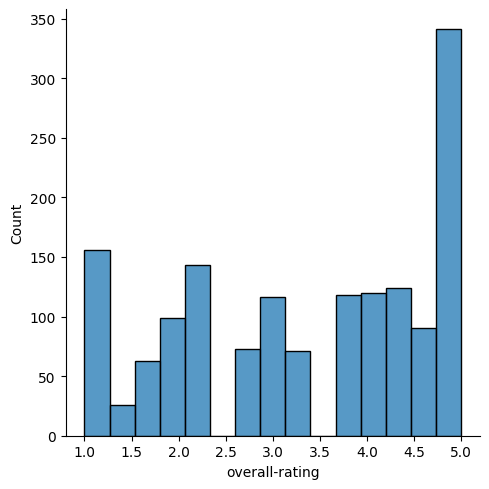

In [4]:
ax = sns.displot(corpus, x='overall-rating', bins=15)
# midpoints = [rect.get_x() + rect.get_width() / 2 for rect in ax.patches]
# ax.set_xticks(midpoints)

plt.show()

<Axes: xlabel='rating_rounded', ylabel='count'>

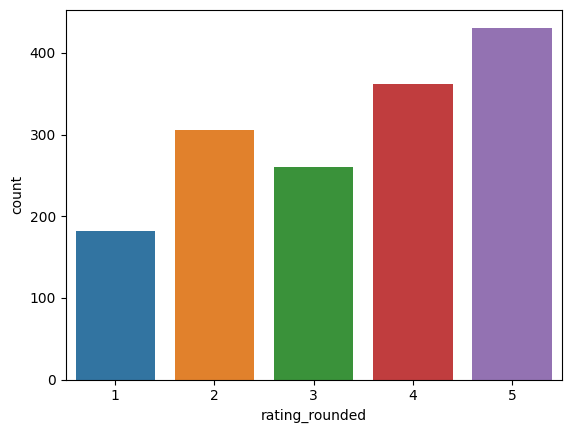

In [5]:
corpus['rating_rounded'] = corpus['overall-rating'].round().astype(int)
sns.countplot(corpus, x='rating_rounded')

## Text Preprocessing
https://geeksforgeeks.org/python-word-embedding-using-word2vec/ \
https://spotintelligence.com/2022/12/21/nltk-preprocessing-pipeline/

In [6]:
# make into sklearn pipeline

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# add spell checking
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens_lower = [token.lower() for token in tokens]
    tokens_no_punct = [token for token in tokens_lower if token not in string.punctuation]
    # tokens_no_stopwords = [token for token in tokens_no_punct if token not in stopwords]
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens_no_punct]
    sentence = ' '.join(tokens_lemmatized)
    return sentence

In [7]:
corpus['text_preprocessed'] = corpus['description-text'].apply(preprocess_text)
corpus['text_preprocessed'].head(5)

0    i 've taken abilify to augment bupropion for b...
1    worked for 3 month waste of time you think you...
2    worked really well for like 2 month then i got...
3    this is the worst drug on the market it caused...
4    i wa prescribed a a child at 15 year old it ca...
Name: text_preprocessed, dtype: object

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

VOCAB_SIZE = 3000
MAX_SEQUENCE_LENGTH = 200

tokenizer = Tokenizer(oov_token='<OOV>', num_words=VOCAB_SIZE)

sentences = corpus['text_preprocessed']

# generate word indexes
tokenizer.fit_on_texts(sentences)

# generate sequences and apply padding
sequences = tokenizer.texts_to_sequences(sentences)
sequences_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [9]:
words_sentences = [x.split() for x in sentences]

## Set up Evaluation Metrics

In [10]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix

def evaluation(y_test, y_pred):
    print(f'accuracy: {accuracy_score(y_test, y_pred):.4f}')

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    cm = confusion_matrix(y_test, y_pred)
    classes = np.unique(y_test) + 1  # sorted in ascending order
    cm_plot = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm_plot.plot(cmap='Blues', ax=ax)
    im = cm_plot.im_
    im.colorbar.remove()
    plt.colorbar(im, orientation='horizontal', pad=0.2, label='Number of samples')

    plt.title('');

## Bag of Words and Naive Bayes
Adapted from Natural Language Processing in Action book[](http://)

In [11]:
# produce BOW

from collections import Counter                                    

bags_of_words = [Counter(sentence) for sentence in words_sentences]
df_bows = pd.DataFrame.from_records(bags_of_words)                  
df_bows = df_bows.fillna(0).astype(int)
df_bows.head(5)

,i,'ve,taken,abilify,to,augment,bupropion,for,bipolar,disorder,...,true,unhappy,environment,behind,wheel,full-blown,interferes,exhuasted,weekend,alleviating
0,4,2,1,1,1,1,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,3,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# train-test split

from sklearn.model_selection import train_test_split

y = corpus['rating_rounded'] - 1  # get labels 0-4 instead of 1-5

test_fraction = 0.2
X_train, X_test, y_train, y_test = train_test_split(df_bows,
                                                    y,
                                                    test_size=test_fraction,
                                                    shuffle=True,
                                                    random_state=0
                                                    )

# subset of 1 and 5 star ratings
keep_train = (y_train == 0) | (y_train == 4)
keep_test = (y_test == 0) | (y_test == 4)

X_train_subset = X_train[keep_train]
y_train_subset = y_train[keep_train]
y_train_subset = np.array([y if y==0 else 1 for y in y_train_subset])

X_test_subset = X_test[keep_test]
y_test_subset = y_test[keep_test]
y_test_subset = np.array([y if y==0 else 1 for y in y_test_subset])

accuracy: 0.7481


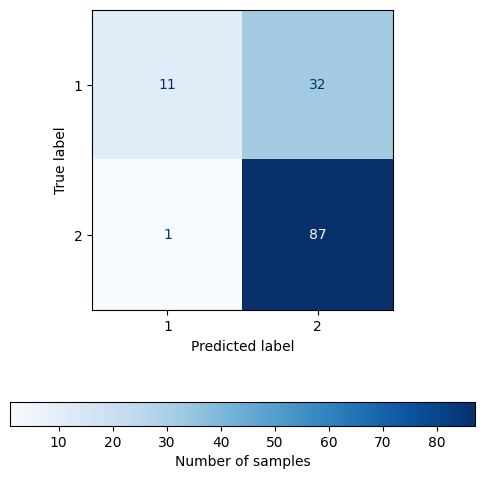

In [13]:
# fit naive Bayes, predict, and evaluate performance

from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train_subset, y_train_subset)

y_pred = model.predict(X_test_subset)

evaluation(y_test_subset, y_pred)

In [14]:
# inspect some misclassified samples

one_star_misclassified = X_test_subset[(y_test_subset == 0) & (y_pred == 1)]
for row in one_star_misclassified.iterrows():
    print(one_star_misclassified.columns[row[1] != 0])

Index(['i', 'abilify', 'now', 'it', ''s', 'effect', 'of', '2', 'just', 'than',
       'before', 'long', 'eating', 'an', 'about', 'ago', 'how', 'feel', 'am',
       'le', 'health', 'began', '...', 'concerned', 'sleeping', 'nausea',
       'wks', 'horrible..trouble', 'thrapeutic', 'rn..and', 'risks/side',
       'vs.', 'desired', 'helpfullness'],
      dtype='object')
Index(['i', 'to', 'and', 'it', 'the', 'from', 'all', 'my', 'wa', 'with',
       'having', 'on', 'over', 'or', 'out', 'very', 'up', 'rash', 'body',
       'felt', 'when', 'sent', 'energy', 'right', 'came', 'room', 'emergency',
       'ended', 'emotion', 'switched', 'geodon', 'numb', 'inside', 'welt',
       'true', 'unhappy'],
      dtype='object')
Index(['i', 'to', 'for', 'and', 'depression', 'year', 'it', 'the', 'a', 'of',
       'better', 'really', 'my', 'with', 'this', 'is', 'on', 'me', 'company',
       'in', 'an', 'insurance', 'added', 'issue', 'feeling', 'helped', 'am',
       'until', 'when', 'first', 'finally', 'muc

## TF-IDF and Latent Semantic Analysis (LSA)
Adapted from Natural Language Processing in Action book[](http://)

In [18]:
# produce TF-IDF matrix

from sklearn.feature_extraction.text import TfidfVectorizer

extreme_bool = (y == 0) | (y == 4)

tfidf_model = TfidfVectorizer()
tfidf_matrix = tfidf_model.fit_transform(sentences[extreme_bool]).toarray()
tfidf_matrix = tfidf_matrix - tfidf_matrix.mean(axis=0) # center data
tfidf_matrix[:5]

array([[-0.00103765, -0.00031817, -0.00117231, ..., -0.00156102,
        -0.00035337, -0.00250326],
       [-0.00103765, -0.00031817, -0.00117231, ..., -0.00156102,
        -0.00035337, -0.00250326],
       [-0.00103765, -0.00031817, -0.00117231, ..., -0.00156102,
        -0.00035337, -0.00250326],
       [-0.00103765, -0.00031817, -0.00117231, ..., -0.00156102,
        -0.00035337, -0.00250326],
       [-0.00103765, -0.00031817, -0.00117231, ..., -0.00156102,
        -0.00035337, -0.00250326]])

In [19]:
# perform truncated SVD

from sklearn.decomposition import TruncatedSVD
 
svd = TruncatedSVD(n_components=16, n_iter=100)
svd_topic_vectors = svd.fit_transform(tfidf_matrix)

<Axes: >

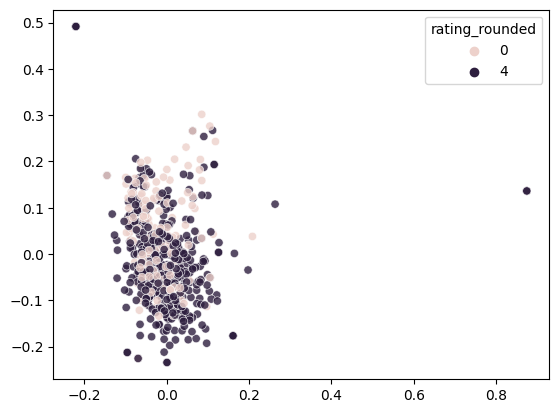

In [22]:
x_coord = np.array([doc[0] for doc in svd_topic_vectors])
y_coord = np.array([doc[1] for doc in svd_topic_vectors])

sns.scatterplot(x=x_coord, y=y_coord, hue=y[extreme_bool], alpha=0.8)

## Word2Vec and Convolutional Neural Network (CNN)

In [23]:
EMBEDDING_DIM = 300

w2v_file = '/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin'
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(w2v_file, binary=True)

In [24]:
# https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [25]:
word_index = tokenizer.word_index
word_list = sorted(word_index.items(), key=lambda x:x[1])
word_list = [x[0] for x in word_list]

embedding_matrix = np.vstack([np.zeros([1, EMBEDDING_DIM]),
                             np.array([w2v_model[word] if word in w2v_model else np.zeros(EMBEDDING_DIM) for word in word_list])])

In [26]:
np.array(word_list)[np.sum(embedding_matrix[1:], axis=1)==0]

array(['<OOV>', 'and', 'to', 'a', 'of', 'abilify', "'s", '10', "''", '15',
       '30', '10mg', '50', '20', '15mg', '40', '60lbs', '20mg', 'pristiq',
       'ocd', '300mg', '100', '14', 'ablify', '60', 'trazadone', 'wasnt',
       '700', '18', 'ptsd', '25', 'geodon', '300', '30mg', '00', '12',
       '45', '1wk', '60mg', '24', 'ambilify', 'didnt', 'it�s', "tic'ing",
       '80', '16', 'lightheadness', 'risperdal', 'abilfy', '150mg',
       '40lbs', '100mg', '500', '38', '99', '70lbs', 'i�ve', '250mg',
       'luvox', '200', '35', 'ssri', '17', '90', 'remeron', 'cogentin',
       '200mg', '20lbs', '19', 'naushish', 'delousions', 'deffently',
       'pristq', 'stabalizede', 'doesnt', 'tmj', 'ariproprazole',
       'pyschiatrists', 'kolopin', 'deppression', 'lemictal', '150',
       '25mg', '225mg', '125', '2009', 'saphris', 'webmd', '30lbs', '11',
       '09', 'clonic', 'benztropine', 'akathesia', 'wbc', '13', 'torette',
       '50mg', 'grey', '117', 'i�ll', '600mg', '450', '40mg', 'viib

In [27]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [28]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras import Model

# 1 and 5 star ratings only
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 3, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [29]:
test_fraction = 0.2
X_train, X_test, y_train, y_test = train_test_split(sequences_padded,
                                                    y,
                                                    test_size=test_fraction,
                                                    shuffle=True,
                                                    random_state=0
                                                    )

# subset of 1 and 5 star ratings
keep_train = (y_train == 0) | (y_train == 4)
keep_test = (y_test == 0) | (y_test == 4)

X_train_subset = X_train[keep_train]
y_train_subset = y_train[keep_train]
y_train_subset = np.array([y if y==0 else 1 for y in y_train_subset])

X_test_subset = X_test[keep_test]
y_test_subset = y_test[keep_test]
y_test_subset = np.array([y if y==0 else 1 for y in y_test_subset])

In [30]:
from sklearn.utils import class_weight

classes = [0, 1]
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train_subset)
class_weights = dict(enumerate(class_weights))

In [31]:
model.fit(X_train_subset,
          y_train_subset,
          epochs=50,
          batch_size=32,
          validation_split=0.1,
          class_weight=class_weights)

y_pred = model.predict(X_test_subset)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/50
14/14 [==============================] - 10s 41ms/step - loss: 0.6940 - accuracy: 0.5727 - val_loss: 0.7188 - val_accuracy: 0.3469
Epoch 2/50
14/14 [==============================] - 0s 7ms/step - loss: 0.6924 - accuracy: 0.4573 - val_loss: 0.6824 - val_accuracy: 0.6327
Epoch 3/50
14/14 [==============================] - 0s 7ms/step - loss: 0.6728 - accuracy: 0.5635 - val_loss: 0.6764 - val_accuracy: 0.6327
Epoch 4/50
14/14 [==============================] - 0s 7ms/step - loss: 0.6458 - accuracy: 0.6952 - val_loss: 0.6426 - val_accuracy: 0.6939
Epoch 5/50
14/14 [==============================] - 0s 7ms/step - loss: 0.5784 - accuracy: 0.7390 - val_loss: 0.6797 - val_accuracy: 0.6122
Epoch 6/50
14/14 [==============================] - 0s 7ms/step - loss: 0.4904 - accuracy: 0.7691 - val_loss: 0.4961 - val_accuracy: 0.7143
Epoch 7/50
14/14 [==============================] - 0s 7ms/step - loss: 0.4594 - accuracy: 0.7991 - val_loss: 0.5843 - val_accuracy: 0.6735
Epoch 8/50
14/14 [

accuracy: 0.7863


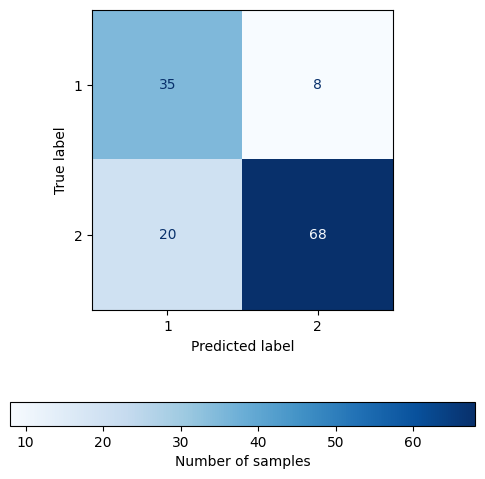

In [32]:
evaluation(y_test_subset, y_pred_label)

In [33]:
# 1 through 5 star ratings
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = Conv1D(64, 3, activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.1)(x)
x = Dense(64, activation='relu')(x)
preds = Dense(5, activation='softmax')(x)

model = Model(sequence_input, preds)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [34]:
classes = [0, 1, 2, 3, 4]
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(enumerate(class_weights))

In [35]:
model.fit(X_train,
          y_train,
          epochs=50,
          batch_size=32,
          validation_split=0.1,
          class_weight=class_weights)

y_pred = model.predict(X_test)
y_pred_label = [np.argmax(y) for y in y_pred]

Epoch 1/50
35/35 [==============================] - 3s 26ms/step - loss: 1.6128 - accuracy: 0.2139 - val_loss: 1.6095 - val_accuracy: 0.2742
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 1.5428 - accuracy: 0.3502 - val_loss: 1.6318 - val_accuracy: 0.2097
Epoch 3/50
35/35 [==============================] - 0s 5ms/step - loss: 1.3504 - accuracy: 0.4621 - val_loss: 1.7381 - val_accuracy: 0.2500
Epoch 4/50
35/35 [==============================] - 0s 5ms/step - loss: 1.0362 - accuracy: 0.6408 - val_loss: 1.7724 - val_accuracy: 0.2823
Epoch 5/50
35/35 [==============================] - 0s 5ms/step - loss: 0.7834 - accuracy: 0.7545 - val_loss: 1.9533 - val_accuracy: 0.2419
Epoch 6/50
35/35 [==============================] - 0s 5ms/step - loss: 0.6510 - accuracy: 0.7960 - val_loss: 2.0659 - val_accuracy: 0.3306
Epoch 7/50
35/35 [==============================] - 0s 5ms/step - loss: 0.5448 - accuracy: 0.8366 - val_loss: 2.1931 - val_accuracy: 0.2661
Epoch 8/50
35/35 [=

accuracy: 0.2825


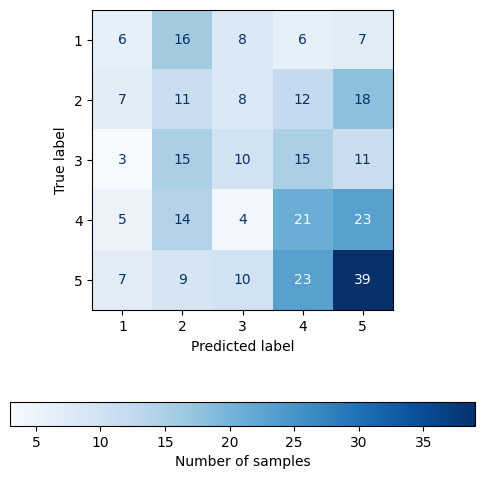

In [36]:
evaluation(y_test, y_pred_label)